In [1]:
%matplotlib inline


Core Concepts
=============

This tutorial introduces Documents, Corpora, Vectors and Models: the basic concepts and terms needed to understand and use gensim.


In [106]:
import pprint
import os


In [107]:
def remove_extra(doctext):
    """
    Remove extra characters that are not to be used in the analysis
    """
    
    doc = doctext.replace('# Reusable Component Library System Security Plan', "").replace('```text', "").replace('```', '').replace("'", "").replace('*', "")
    return doc

In [108]:
# Folder with controls
root = f"{os.getcwd()}\docs\controls"

AC_doc = """{}""".format(open(f'{root}\AC.md', encoding="utf8").read())
AP_doc = """{}""".format(open(f'{root}\AP.md', encoding="utf8").read())
AR_doc = """{}""".format(open(f'{root}\AR.md', encoding="utf8").read())

# Cleaning
AC_doc = remove_extra(AC_doc)
AP_doc = remove_extra(AP_doc)
AR_doc = remove_extra(AR_doc)

# clean up
print(AC_doc)



# NIST SP 800-53 Revision 4

## AC: Access Control

### AC-1: Access Control Policy And Procedures


The organization:
  a.  Develops, documents, and disseminates to [Assignment: organization-defined
personnel or roles]:
    1.  An access control policy that addresses purpose, scope, roles, responsibilities,
management commitment, coordination among organizational entities, and compliance; and
    2.  Procedures to facilitate the implementation of the access control policy
and associated access controls; and
  b.  Reviews and updates the current:
    1.  Access control policy [Assignment: organization-defined frequency]; and
    2.  Access control procedures [Assignment: organization-defined frequency].


Status: Complete

##### CivicActions

CivicActions has developed, documented and disseminated to personnel an access control policy that addresses purpose, scope, roles, responsibilities, management commitment, coordination among organizational entities, and compliance; and procedur

In [109]:
# control corpus

text_corpus = [
    AC_doc,
    AP_doc,
    AR_doc
]

In [136]:
# Create a set of frequent words
stoplist = set("for a of the and to in as are or and/or * # ## ### #### ##### – - 1. 2. 3. 4. 1 2 3 4 a. b. c. d. a b c d".split(' '))

# Lowercase each document, split it by white space and filter out stopwords
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in text_corpus]

# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

# Only keep words that appear more than once
processed_corpus = [[token for token in text if frequency[token] > 1] for text in texts]
#pprint.pprint(processed_corpus)

In [137]:
from gensim import corpora

dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)
pprint.pprint(dictionary.token2id)

Dictionary(449 unique tokens: ['(ac)', '(e.g.', '(iam)', '800-53', '[assignment:']...)
{'"the': 409,
 '(ac)': 0,
 '(e.g.': 1,
 '(iam)': 2,
 '(pii)': 410,
 '800-53': 3,
 '[assignment:': 4,
 'access': 5,
 'access.': 6,
 'access;': 7,
 'accessible': 8,
 'accessing': 9,
 'accordance': 10,
 'according': 11,
 'account': 12,
 'account/node': 13,
 'accounting': 423,
 'accounts': 14,
 'accounts.': 15,
 'accounts;': 16,
 'action': 17,
 'actions': 18,
 'activities': 19,
 'additional': 20,
 'address': 411,
 'addresses': 21,
 'admin': 22,
 'administration,': 23,
 'administrative': 24,
 'administrator': 25,
 'administrator,': 26,
 'administrators': 27,
 'after': 28,
 'agency': 29,
 'align': 30,
 'all': 31,
 'allow': 32,
 'allowing': 33,
 'allows.': 34,
 'amazon': 35,
 'among': 36,
 'an': 37,
 'anonymous': 38,
 'any': 39,
 'api': 40,
 'applicable': 41,
 'applicable.': 42,
 'application': 43,
 'appropriate': 44,
 'approvals': 45,
 'approved': 46,
 'architecture,': 47,
 'assigned': 48,
 'assigns': 49,


In [138]:
new_doc = "Access Documents"
new_vec = dictionary.doc2bow(new_doc.lower().split())
print(new_vec)

[(5, 1), (129, 1)]


In [139]:
# convert our entire original corpus to a list of vectors:

In [140]:
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
pprint.pprint(bow_corpus)

[[(0, 2),
  (1, 2),
  (2, 3),
  (3, 1),
  (4, 15),
  (5, 87),
  (6, 2),
  (7, 2),
  (8, 12),
  (9, 2),
  (10, 7),
  (11, 4),
  (12, 36),
  (13, 2),
  (14, 35),
  (15, 6),
  (16, 3),
  (17, 2),
  (18, 5),
  (19, 1),
  (20, 1),
  (21, 2),
  (22, 2),
  (23, 2),
  (24, 2),
  (25, 11),
  (26, 2),
  (27, 4),
  (28, 3),
  (29, 2),
  (30, 2),
  (31, 21),
  (32, 4),
  (33, 4),
  (34, 2),
  (35, 9),
  (36, 2),
  (37, 23),
  (38, 12),
  (39, 9),
  (40, 2),
  (41, 2),
  (42, 3),
  (43, 3),
  (44, 4),
  (45, 2),
  (46, 2),
  (47, 3),
  (48, 5),
  (49, 3),
  (50, 5),
  (51, 4),
  (52, 9),
  (53, 4),
  (54, 2),
  (55, 1),
  (56, 2),
  (57, 1),
  (58, 7),
  (59, 2),
  (60, 3),
  (61, 4),
  (62, 17),
  (63, 4),
  (64, 3),
  (65, 12),
  (66, 4),
  (67, 3),
  (68, 2),
  (69, 13),
  (70, 2),
  (71, 8),
  (72, 5),
  (73, 2),
  (74, 2),
  (75, 2),
  (76, 1),
  (77, 27),
  (78, 11),
  (79, 2),
  (80, 2),
  (81, 2),
  (82, 31),
  (83, 2),
  (84, 3),
  (85, 2),
  (86, 2),
  (87, 2),
  (88, 3),
  (89, 11),
  (9

Note that while this list lives entirely in memory, in most applications you
will want a more scalable solution. Luckily, ``gensim`` allows you to use any
iterator that returns a single document vector at a time. See the
documentation for more details.

.. Important::
  The distinction between a document and a vector is that the former is text,
  and the latter is a mathematically convenient representation of the text.
  Sometimes, people will use the terms interchangeably: for example, given
  some arbitrary document ``D``, instead of saying "the vector that
  corresponds to document ``D``", they will just say "the vector ``D``" or
  the "document ``D``".  This achieves brevity at the cost of ambiguity.

  As long as you remember that documents exist in document space, and that
  vectors exist in vector space, the above ambiguity is acceptable.

.. Important::
  Depending on how the representation was obtained, two different documents
  may have the same vector representations.


Model
-----

Now that we have vectorized our corpus we can begin to transform it using
*models*. We use model as an abstract term referring to a *transformation* from
one document representation to another. In ``gensim`` documents are
represented as vectors so a model can be thought of as a transformation
between two vector spaces. The model learns the details of this
transformation during training, when it reads the training
`core_concepts_corpus`.

One simple example of a model is `tf-idf
<https://en.wikipedia.org/wiki/Tf%E2%80%93idf>`_.  The tf-idf model
transforms vectors from the bag-of-words representation to a vector space
where the frequency counts are weighted according to the relative rarity of
each word in the corpus.

Here's a simple example. Let's initialize the tf-idf model, training it on
our corpus and transforming the string "system minors":




In [141]:
from gensim import models

# train the model
tfidf = models.TfidfModel(bow_corpus)

# transform the "system minors" string
words = "access security".lower().split()
print(tfidf[dictionary.doc2bow(words)])

[(336, 1.0)]


In [142]:
from gensim import similarities

index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=len(dictionary.token2id)) # len(dictionary.token2id) is the number of features

and to query the similarity of our query document ``query_document`` against every document in the corpus:



In [143]:
#query_document = 'access security'.split()
query_document = texts[0]# AC.md after all pre-processing
query_bow = dictionary.doc2bow(query_document)
sims = index[tfidf[query_bow]]
print(list(enumerate(sims)))

[(0, 0.99999964), (1, 0.06376363), (2, 0.06568639)]


How to read this output?
Document 1 has a similarity score of 0.99999994=99%, document 2 has a similarity score of 6% etc.
We can make this slightly more readable by sorting:



In [144]:
for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True):
    print(document_number, score)

0 0.99999964
2 0.06568639
1 0.06376363


# Word clouds
Need the wordcloud library


In [145]:
#pip install wordcloud

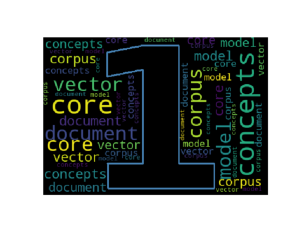

In [146]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('run_core_concepts.png')
imgplot = plt.imshow(img)
_ = plt.axis('off')

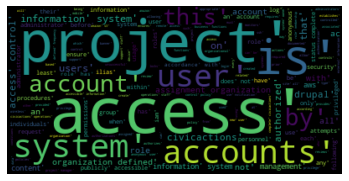

In [147]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Start with one document:
text = str(texts[0])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

wordcloud.to_file("img/AC_wordcloud_example.png")


In [148]:
pprint.pprint(text)

("['nist', 'sp', '800-53', 'revision', 'ac:', 'access', 'control', 'ac-1:', "
 "'access', 'control', 'policy', 'procedures', 'organization:', 'develops,', "
 "'documents,', 'disseminates', '[assignment:', 'organization-defined', "
 "'personnel', 'roles]:', 'an', 'access', 'control', 'policy', 'that', "
 "'addresses', 'purpose,', 'scope,', 'roles,', 'responsibilities,', "
 "'management', 'commitment,', 'coordination', 'among', 'organizational', "
 "'entities,', 'compliance;', 'procedures', 'facilitate', 'implementation', "
 "'access', 'control', 'policy', 'associated', 'access', 'controls;', "
 "'reviews', 'updates', 'current:', 'access', 'control', 'policy', "
 "'[assignment:', 'organization-defined', 'frequency];', 'access', 'control', "
 "'procedures', '[assignment:', 'organization-defined', 'frequency].', "
 "'status:', 'complete', 'civicactions', 'civicactions', 'has', 'developed,', "
 "'documented', 'disseminated', 'personnel', 'an', 'access', 'control', "
 "'policy', 'that', 'add